In [51]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Interpolation

In [52]:
df = pd.DataFrame(
    {
        'name': ['A','A', 'B','B','B','B', 'C','C','C'],
        'value': [1, np.nan, np.nan, 2, 3, 1, 3, np.nan, 3],
    }
)

In [53]:
df

,name,value
0,A,1.0
1,A,NaN
2,B,NaN
3,B,2.0
4,B,3.0
5,B,1.0
6,C,3.0
7,C,NaN
8,C,3.0


In [54]:
df.fillna(method="pad")

,name,value
0,A,1.0
1,A,1.0
2,B,1.0
3,B,2.0
4,B,3.0
5,B,1.0
6,C,3.0
7,C,3.0
8,C,3.0


In [55]:
df['value'].interpolate()

0    1.000000
1    1.333333
2    1.666667
3    2.000000
4    3.000000
5    1.000000
6    3.000000
7    3.000000
8    3.000000
Name: value, dtype: float64

In [56]:
df['value'].interpolate(method="quadratic")

0    1.000000
1    0.630605
2    0.963938
3    2.000000
4    3.000000
5    1.000000
6    3.000000
7    4.024674
8    3.000000
Name: value, dtype: float64

In [57]:
# For cumsums
df['value'].interpolate(method="pchip")

0    1.000000
1    1.138047
2    1.498316
3    2.000000
4    3.000000
5    1.000000
6    3.000000
7    3.000000
8    3.000000
Name: value, dtype: float64

### LSTM

In [58]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('data/raw_pollution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

In [59]:
# mark all NA values with 0
dataset['pollution'] = dataset['pollution'].interpolate()
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('data/pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


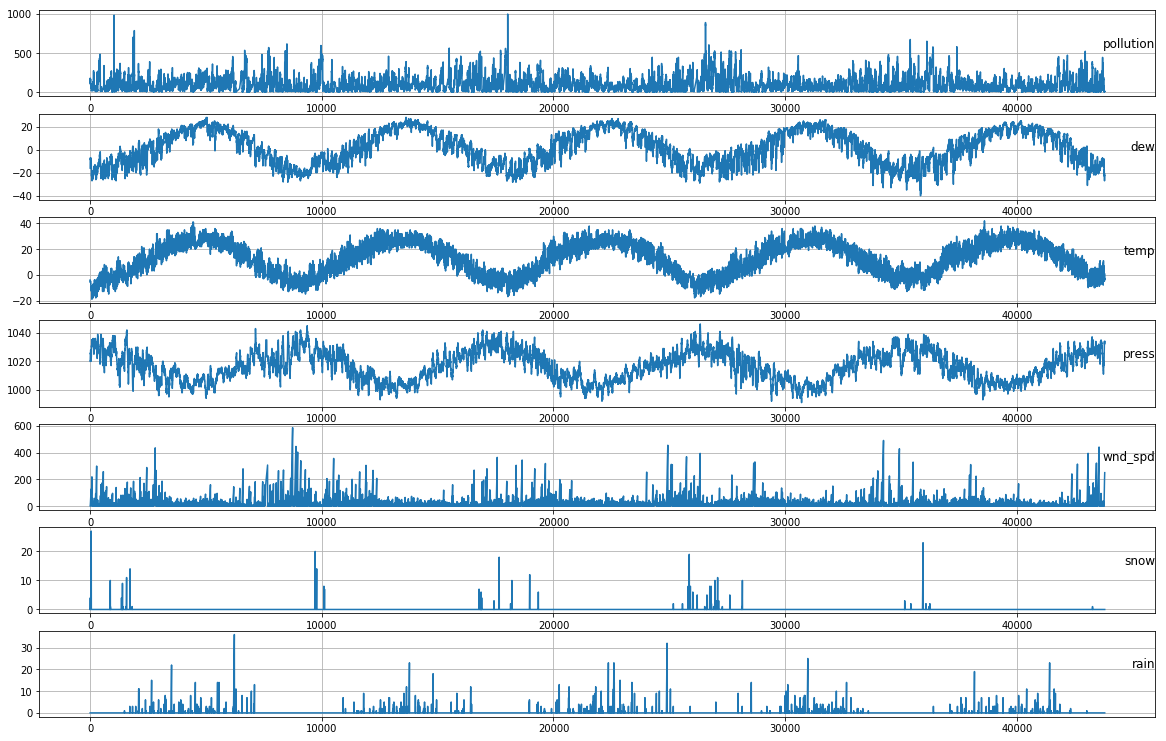

In [60]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure(figsize=(20, 13))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    pyplot.grid()
    i += 1
pyplot.show()

In [71]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
dataset = read_csv('data/pollution.csv', header=0, index_col=0)
values = dataset.values

In [72]:
dataset

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
2010-01-02 05:00:00,109.0,-7,-6.0,1022.0,SE,7.14,3,0
2010-01-02 06:00:00,105.0,-7,-6.0,1023.0,SE,8.93,4,0
2010-01-02 07:00:00,124.0,-7,-5.0,1024.0,SE,10.72,0,0
2010-01-02 08:00:00,120.0,-8,-6.0,1024.0,SE,12.51,0,0


In [73]:
values

array([[129.0, -16, -4.0, ..., 1.79, 0, 0],
       [148.0, -15, -4.0, ..., 2.68, 0, 0],
       [159.0, -11, -5.0, ..., 3.57, 0, 0],
       ...,
       [10.0, -22, -3.0, ..., 242.7, 0, 0],
       [8.0, -22, -4.0, ..., 246.72, 0, 0],
       [12.0, -21, -3.0, ..., 249.85, 0, 0]], dtype=object)

In [74]:
# integer encode wind_direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


In [75]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


We will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution. The input shape will be 1 time step with 8 features.

We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

Train on 8760 samples, validate on 35039 samples
Epoch 1/50
8760/8760 [==============================] - 3s 337us/step - loss: 0.0548 - val_loss: 0.0534
Epoch 2/50
8760/8760 [==============================] - 1s 170us/step - loss: 0.0332 - val_loss: 0.0570
Epoch 3/50
8760/8760 [==============================] - 2s 234us/step - loss: 0.0193 - val_loss: 0.0377
Epoch 4/50
8760/8760 [==============================] - 1s 161us/step - loss: 0.0151 - val_loss: 0.0237
Epoch 5/50
8760/8760 [==============================] - 1s 141us/step - loss: 0.0140 - val_loss: 0.0173
Epoch 6/50
8760/8760 [==============================] - 1s 121us/step - loss: 0.0139 - val_loss: 0.0157
Epoch 7/50
8760/8760 [==============================] - 1s 104us/step - loss: 0.0137 - val_loss: 0.0151
Epoch 8/50
8760/8760 [==============================] - 1s 110us/step - loss: 0.0138 - val_loss: 0.0150
Epoch 9/50
8760/8760 [==============================] - 1s 149us/step - loss: 0.0138 - val_loss: 0.0150
Epoch 10/50
876

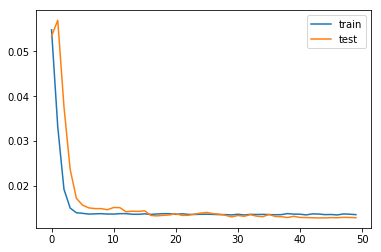

In [76]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=64, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [77]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 23.355


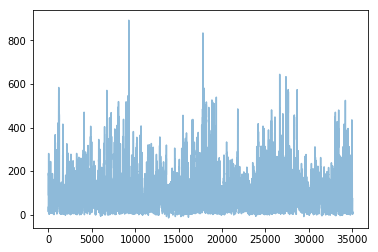

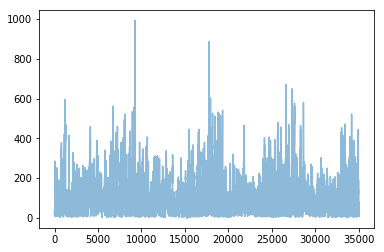

In [91]:
pyplot.plot(range(len(inv_yhat)), inv_yhat, alpha=0.5, label="Predicted")
pyplot.show()
pyplot.plot(range(len(inv_y)), inv_y, alpha=0.5, label="Expected")
pyplot.show()

### N previous lags

In [108]:
# load dataset
dataset = read_csv('data/pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 3
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

(43797, 32)


Next, we need to be more careful in specifying the column for input and output.

We have 3 * 8 + 8 columns in our framed dataset. We will take 3 * 8 or 24 columns as input for the obs of all features across the previous 3 hours. We will take just the pollution variable as output at the following hour, as follows:

In [110]:
 # split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours]
test = values[n_train_hours:]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

(8760, 24) 8760 (8760,)
(8760, 3, 8) (8760,) (35037, 3, 8) (35037,)


In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

Train on 8760 samples, validate on 35037 samples
Epoch 1/50
 - 3s - loss: 0.0436 - val_loss: 0.0702
Epoch 2/50
 - 2s - loss: 0.0261 - val_loss: 0.0502
Epoch 3/50
 - 2s - loss: 0.0215 - val_loss: 0.0291
Epoch 4/50
 - 2s - loss: 0.0201 - val_loss: 0.0205
Epoch 5/50
 - 2s - loss: 0.0195 - val_loss: 0.0188
Epoch 6/50
 - 2s - loss: 0.0185 - val_loss: 0.0175
Epoch 7/50
 - 2s - loss: 0.0179 - val_loss: 0.0164
Epoch 8/50
 - 2s - loss: 0.0176 - val_loss: 0.0161
Epoch 9/50
 - 1s - loss: 0.0171 - val_loss: 0.0155
Epoch 10/50
 - 1s - loss: 0.0167 - val_loss: 0.0152
Epoch 11/50
 - 2s - loss: 0.0161 - val_loss: 0.0149
Epoch 12/50
 - 1s - loss: 0.0159 - val_loss: 0.0141
Epoch 13/50
 - 1s - loss: 0.0153 - val_loss: 0.0138
Epoch 14/50
 - 1s - loss: 0.0150 - val_loss: 0.0133
Epoch 15/50
 - 1s - loss: 0.0149 - val_loss: 0.0138
Epoch 16/50
 - 1s - loss: 0.0147 - val_loss: 0.0137
Epoch 17/50
 - 2s - loss: 0.0143 - val_loss: 0.0138
Epoch 18/50
 - 2s - loss: 0.0140 - val_loss: 0.0129
Epoch 19/50
 - 1s - loss

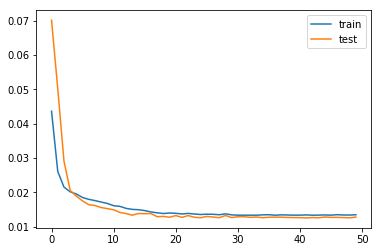

In [113]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, 
                    batch_size=64, validation_data=(test_X, test_y), 
                    verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [114]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 22.785
